<a href="https://colab.research.google.com/github/keerthanab2201/Sentiment-Analysis-using-Deep-Learning/blob/main/CNN_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Collection

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load csv file and preview
import pandas as pd
df= pd.read_csv("/content/drive/MyDrive/datasets/Amazon-Product-Reviews-Sentiment-Analysis-in-Python-Dataset.csv")
print(df.head())

                                              Review  Sentiment
0  Fast shipping but this product is very cheaply...          1
1  This case takes so long to ship and it's not e...          1
2  Good for not droids. Not good for iPhones. You...          1
3  The cable was not compatible between my macboo...          1
4  The case is nice but did not have a glow light...          1


In [5]:
# Save as a JSON file(records format)
df.to_json("amazon_reviews_data.json", orient="records", lines=True)
print("✅ Conversion complete: Saved as reviews_data.json")

✅ Conversion complete: Saved as reviews_data.json


##Data Pre-Processing

* lowercase
* stopword removal
* punctuation removal
* one word review removal
* contraction removal
* tokenization
* part of speech tagging

In [6]:
# installing dependencies
!pip install contractions textblob gensim beautifulsoup4
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
# Step 2: Import Modules
import re
import pandas as pd
import nltk
import numpy as np
import gensim
from bs4 import BeautifulSoup
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from contractions import fix as expand_contractions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
# load JSON dataset and inspect columns
df = pd.read_json("amazon_reviews_data.json", lines=True)
print(df.columns)

Index(['Review', 'Sentiment'], dtype='object')


In [10]:
# Drop missing values and filter required columns
text_col = "Review"
label_col = "Sentiment"
df = df[[text_col, label_col]].dropna() #these are the two columns
df.columns = ["text", "rating"]  # Normalize column names

In [13]:
# Define preprocessing function
def preprocess_pipeline(text):
    text = str(text)
    text = expand_contractions(text.lower())            # Lowercase + contractions
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)          # Elongated word normalization
    tokens = word_tokenize(text)                        # Tokenization
    # Optional: Stopwords (skip for deep models)
    # tokens = [t for t in tokens if t not in stop_words]
    tokens = [re.sub(r"[^\w\s!?]", "", t) for t in tokens]  # 5. Remove selective punctuation
    tokens = [t for t in tokens if t.strip() != ""]
    if len(tokens) <= 1:
        return None
    pos_tags = nltk.pos_tag(tokens)
    clean_text = " ".join(tokens)
    polarity_score = TextBlob(clean_text).sentiment.polarity
    return {
        "clean_text": clean_text,
        "tokens": tokens,
        "pos_tags": pos_tags,
        "score": polarity_score
    }


In [14]:
# Apply preprocessing function
processed = df["text"].apply(preprocess_pipeline)
df = df[processed.notnull()].copy()
df["processed"] = processed[processed.notnull()].values

In [15]:
# Extract cleaned data for tokenization
texts = df["processed"].apply(lambda x: x["clean_text"]).tolist()
labels = df["rating"].tolist()
scores = df["processed"].apply(lambda x: x["score"]).tolist()
# Result: Three lists containing the text data, labels, and scores respectively

In [16]:
# Word Embeddings
# Keras Tokenizer- converts raw text into numerical sequences (each word= unique integer index) that can be later processed by Keras layers like Embedding
MAX_VOCAB = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="")
tokenizer.fit_on_texts(texts)
# sequence padding- adding placeholder values (often zeros) to shorter sequences in a dataset to make them all the same length
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post')

In [17]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/glove.6B.zip", "r") as zip_ref:
    zip_ref.extractall("glove")

In [18]:
# Load GloVe and Create Embedding Matrix
#GloVe(Global Vectors for Word Representation)- converts words into numerical vectors(embeddings) that capture semantic relationships between words- unsupervised learning algorithm

embedding_index = {}
with open("glove/glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs

embedding_dim = 100  # matching model spec
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
# Remove neutral reviews and relabel
df = df[df['rating'] != 3]
df['label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0) # creates binary labels: 1 for positive (rating ≥4), 0 for negative

/tmp/ipython-input-19-3232871527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0) # creates binary labels: 1 for positive (rating ≥4), 0 for negative


In [20]:
# Get cleaned texts again
texts = df["processed"].apply(lambda x: x["clean_text"]).tolist()
labels = df["label"].tolist()

In [21]:
# Prepare tokenizer and sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [22]:
vocab_size = 15000
input_length = 400
# creates vocabulary of 15,000 most frequent words, converts text to integer sequences and pads sequences to length 400 (truncating longer texts or padding shorter ones)

In [23]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
padded_sequences = pad_sequences(sequences, maxlen=input_length, padding='post')

word_index = tokenizer.word_index

In [24]:
# setup embedding matrix
# initializes embedding matrix with zeros and fill it with pre-trained GloVe vectors where available
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
# train test split- 70% training / 10% validation / 20% testing
from sklearn.model_selection import train_test_split

# Step 1: Split 20% test set
X_temp, X_test, y_temp, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 2: Split remaining 80% into 70% train and 10% validation
# 70% of full data = 87.5% of remaining 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

print(f"Train size     : {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size      : {len(X_test)}")


Train size     : 13867
Validation size: 1981
Test size      : 3963


##CNN-LSTM Model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import numpy as np

In [27]:
# Custom Attention Layer
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        return tf.reduce_sum(context_vector, axis=1)

In [28]:
# Model hyperparameters
embedding_dim = 100
input_length = 400
num_filters = 128
kernel_size = 3
pool_size = 2
strides = 1
lstm_units = 64
dropout_rate = 0.4

In [29]:
# Build the CNN-LSTM model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Embedding(input_dim=len(word_index)+1,
                             output_dim=embedding_dim,
                             weights=[embedding_matrix],
                             input_length=input_length,
                             trainable=True))

cnn_lstm_model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, strides=strides, activation='relu'))
cnn_lstm_model.add(BatchNormalization())
cnn_lstm_model.add(MaxPooling1D(pool_size=pool_size))

cnn_lstm_model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
cnn_lstm_model.add(Attention())
cnn_lstm_model.add(Dropout(dropout_rate))

cnn_lstm_model.add(Dense(128, activation='relu'))
cnn_lstm_model.add(Dropout(0.3))
cnn_lstm_model.add(Dense(1, activation='sigmoid'))

cnn_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_cnn_lstm_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

In [31]:
# Model fitting
history = cnn_lstm_model.fit(
    X_train, np.array(y_train),
    batch_size=64,
    epochs=20,
    validation_data=(X_val, np.array(y_val)),
    callbacks=[early_stop, lr_scheduler, checkpoint],
    verbose=1
)

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.5820 - loss: 0.6508
Epoch 1: val_loss improved from inf to 0.43326, saving model to best_cnn_lstm_model.h5


217/217 ━━━━━━━━━━━━━━━━━━━━ 222s 966ms/step - accuracy: 0.5825 - loss: 0.6504 - val_accuracy: 0.8112 - val_loss: 0.4333 - learning_rate: 0.0010
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.8454 - loss: 0.3506
Epoch 2: val_loss improved from 0.43326 to 0.30123, saving model to best_cnn_lstm_model.h5


217/217 ━━━━━━━━━━━━━━━━━━━━ 198s 910ms/step - accuracy: 0.8454 - loss: 0.3505 - val_accuracy: 0.8824 - val_loss: 0.3012 - learning_rate: 0.0010
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.8976 - loss: 0.2563
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_loss did not improve from 0.30123
217/217 ━━━━━━━━━━━━━━━━━━━━ 195s 881ms/step - accuracy: 0.8976 - loss: 0.2563 - val_accuracy: 0.8748 - val_loss: 0.3109 - learning_rate: 0.0010
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.9310 - loss: 0.1851
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 4: val_loss did not improve from 0.30123
217/217 ━━━━━━━━━━━━━━━━━━━━ 203s 886ms/step - accuracy: 0.9310 - loss: 0.1851 - val_accuracy: 0.8501 - val_loss: 0.4859 - learning_rate: 5.0000e-04
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.9468 - loss: 0.1537
Epoch 5: ReduceLROnPlateau reducing learning rate

##Model Evaluation

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict
y_pred_prob = cnn_lstm_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print("Confusion Matrix (CNN-LSTM):")
print(cm)
print(f"\nAccuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Specificity  : {specificity:.4f}")

124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step
Confusion Matrix (CNN-LSTM):
[[1708  285]
 [ 200 1770]]

Accuracy     : 0.8776
Precision    : 0.8613
Recall       : 0.8985
F1 Score     : 0.8795
Specificity  : 0.8570


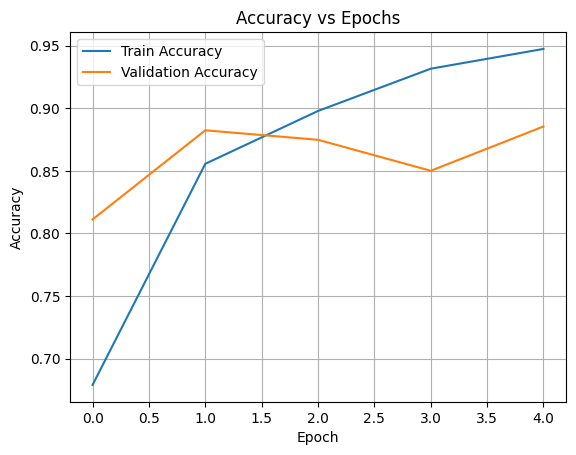

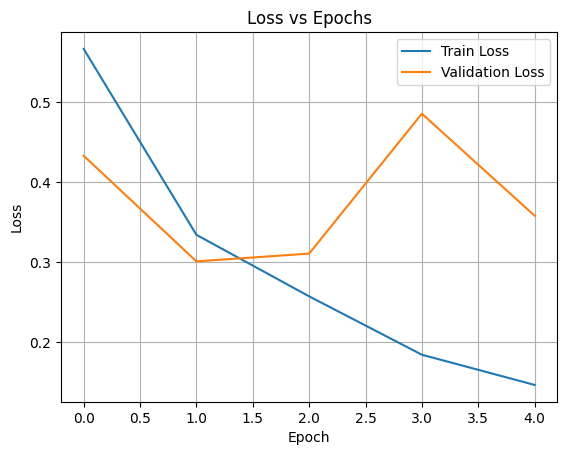

In [36]:
# plot accuracy and loss vs epoch
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()